In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import cycle, islice
import seaborn as sb
import matplotlib.dates as dates
import datetime as dt
from sklearn import preprocessing
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import plotly.graph_objects as go
import plotly_express as px
from sklearn.preprocessing import OrdinalEncoder

In [2]:
ls

__notebook__.ipynb


In [3]:
train = pd.read_csv("/kaggle/input/covid19-global-forecasting-week-4/train.csv")
test = pd.read_csv("/kaggle/input/covid19-global-forecasting-week-4/test.csv")
print(train.head())
print(train.tail())

   Id Country_Region Province_State        Date  ConfirmedCases  Fatalities
0   1    Afghanistan            NaN  2020-01-22             0.0         0.0
1   2    Afghanistan            NaN  2020-01-23             0.0         0.0
2   3    Afghanistan            NaN  2020-01-24             0.0         0.0
3   4    Afghanistan            NaN  2020-01-25             0.0         0.0
4   5    Afghanistan            NaN  2020-01-26             0.0         0.0
          Id Country_Region Province_State        Date  ConfirmedCases  \
24409  35642       Zimbabwe            NaN  2020-04-04             9.0   
24410  35643       Zimbabwe            NaN  2020-04-05             9.0   
24411  35644       Zimbabwe            NaN  2020-04-06            10.0   
24412  35645       Zimbabwe            NaN  2020-04-07            11.0   
24413  35646       Zimbabwe            NaN  2020-04-08            11.0   

       Fatalities  
24409         1.0  
24410         1.0  
24411         1.0  
24412         2.0  

In [4]:
train['Date'] = pd.to_datetime(train['Date'], format = '%Y-%m-%d')
test['Date'] = pd.to_datetime(test['Date'], format = '%Y-%m-%d')
curr_date = train['Date'].max()
world_cum_confirmed = sum(train[train['Date'] == curr_date].ConfirmedCases)
world_cum_fatal = sum(train[train['Date'] == curr_date].Fatalities)
print('Number of Countires: ', len(train['Country_Region'].unique()))
print('Number of confirmed cases: ', world_cum_confirmed)
print('Number of fatal cases: ', world_cum_fatal)
print('End date in train dset: ', curr_date)

Number of Countires:  184
Number of confirmed cases:  1510928.0
Number of fatal cases:  88332.0
End date in train dset:  2020-04-08 00:00:00


In [5]:
train[['ConfirmedCases', 'Fatalities']].describe()

,ConfirmedCases,Fatalities
count,24414.000000,24414.000000
mean,835.249447,39.778201
std,6554.109673,494.078524
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,75.000000,0.000000
max,151061.000000,17669.000000


In [6]:
top_country_c = train[train['Date'] == curr_date].groupby(['Date','Country_Region']).sum().sort_values(['ConfirmedCases'], ascending=False)
top_country_c.head(10)

Id  ConfirmedCases  Fatalities
Date       Country_Region                                     
2020-04-08 US              1626318        428889.0     14690.0
           Spain             25386        148220.0     14792.0
           Italy             16722        139422.0     17669.0
           France           148830        113959.0     10887.0
           Germany           14556        113296.0      2349.0
           China            265914         82809.0      3337.0
           Iran              16266         64586.0      3993.0
           United Kingdom   375804         61474.0      7111.0
           Turkey            26982         38226.0       812.0
           Belgium            2700         23403.0      2240.0

In [7]:
top_country_c.tail() #you can see this all safely contry so you can go to below list contry

Id  ConfirmedCases  Fatalities
Date       Country_Region                                          
2020-04-08 Sao Tome and Principe  24018             4.0         0.0
           Burundi                 4068             3.0         0.0
           Papua New Guinea       22422             2.0         0.0
           South Sudan            25272             2.0         0.0
           Timor-Leste            26526             1.0         0.0

In [8]:
top_country_f = train[train['Date'] == curr_date].groupby(['Date','Country_Region']).sum().sort_values(['Fatalities'], ascending=False)
top_country_f.head(10)

Id  ConfirmedCases  Fatalities
Date       Country_Region                                     
2020-04-08 Italy             16722        139422.0     17669.0
           Spain             25386        148220.0     14792.0
           US              1626318        428889.0     14690.0
           France           148830        113959.0     10887.0
           United Kingdom   375804         61474.0      7111.0
           Iran              16266         64586.0      3993.0
           China            265914         82809.0      3337.0
           Germany           14556        113296.0      2349.0
           Netherlands      105270         20682.0      2255.0
           Belgium            2700         23403.0      2240.0

In [9]:
pr_confirm = train['ConfirmedCases'].value_counts(normalize=True)
pr_fatal = train['Fatalities'].value_counts(normalize=True)

print(f'Percs of fatality = {pr_fatal[1:].sum()*100}%')
print(f'Percs of confirmed case = {pr_confirm[1:].sum()*100}%')

Percs of fatality = 24.70713525026624%
Percs of confirmed case = 48.902269189809125%


In [10]:
def Country_cases(df, ConfirmedCases,*argv):
    f, ax=plt.subplots(figsize=(16,5))
    labels=argv
    for a in argv: 
        country=df.loc[(df['Country_Region']==a)]
        plt.plot(country['Date'],country['ConfirmedCases'],linewidth=3)
        plt.xticks(rotation=40)
        plt.legend(labels)
        ax.set(title='Evolution of the number of cases' )
        
def Country_fatalities(df, Fatalities,*argv):
    f, ax=plt.subplots(figsize=(16,5))
    labels=argv
    for a in argv: 
        country=df.loc[(df['Country_Region']==a)]
        plt.plot(country['Date'],country['Fatalities'],linewidth=3)
        plt.xticks(rotation=40)
        plt.legend(labels)
        ax.set(title='Evolution of the number of fatalities' )

/opt/conda/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning:

Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()



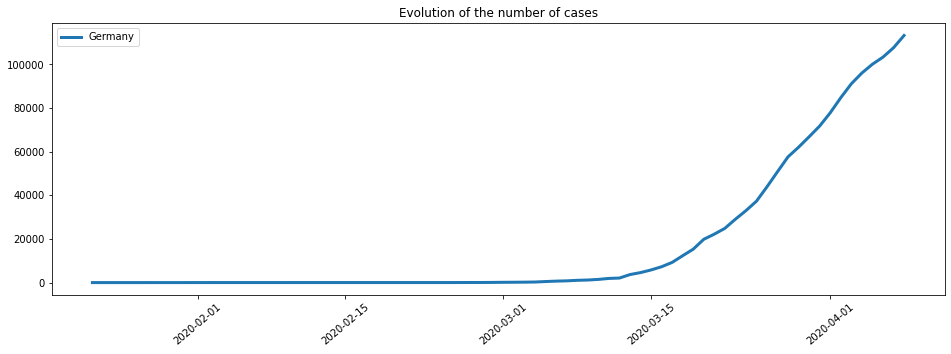

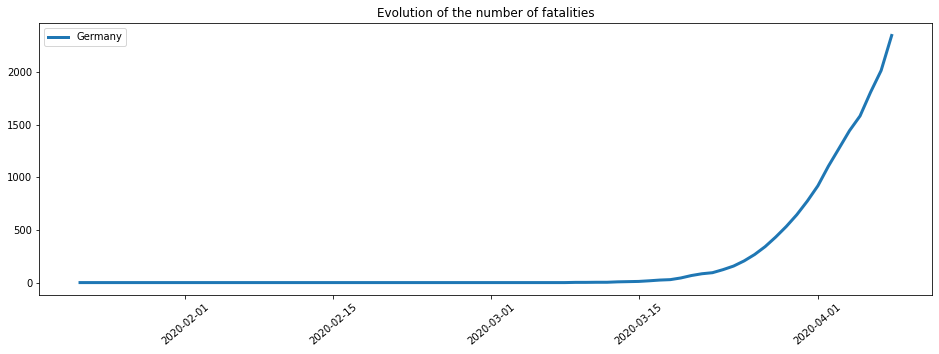

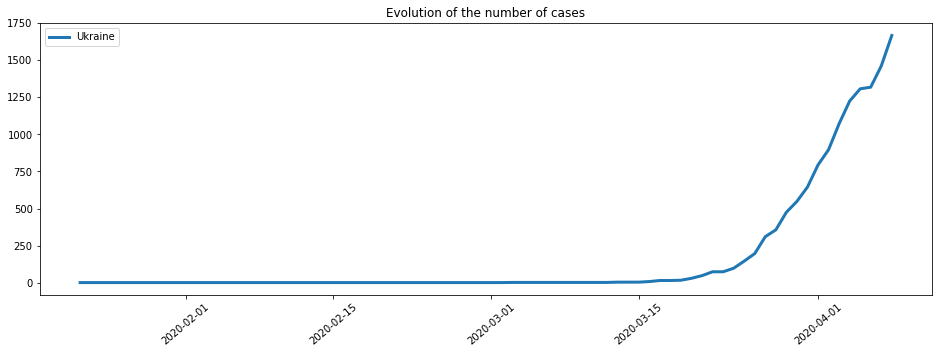

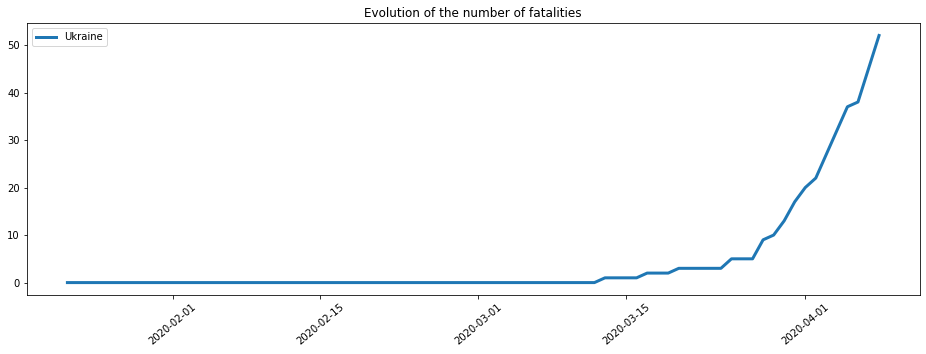

In [11]:
train_sum=train.groupby(['Date','Country_Region']).agg('sum').reset_index()

Country_cases(train_sum,'ConfirmedCases','Germany')
Country_fatalities(train_sum,'Fatalities','Germany')
Country_cases(train_sum,'ConfirmedCases','Ukraine')
Country_fatalities(train_sum,'Fatalities','Ukraine')

In [12]:
case='ConfirmedCases'
def timeCompare(df, time,*argv):
    Coun1=argv[0]
    Coun2=argv[1]
    f,ax=plt.subplots(figsize=(16,5))
    labels=argv  
    country=df.loc[(df['Country_Region']==Coun1)]
    plt.plot(country['Date'],country[case],linewidth=2)
    plt.xticks([])
    plt.legend(labels)
    ax.set(title=' Evolution of actual cases',ylabel='Number of cases' )

    country2=df.loc[df['Country_Region']==Coun2]
    #country2['Date']=country2['Date']-datetime.timedelta(days=time)
    plt.plot(country2['Date'],country2[case],linewidth=2)
    #plt.xticks([])
    plt.legend(labels)
    ax.set(title=' Evolution of cases in %d days difference '%time ,ylabel='Number of %s cases'%case )

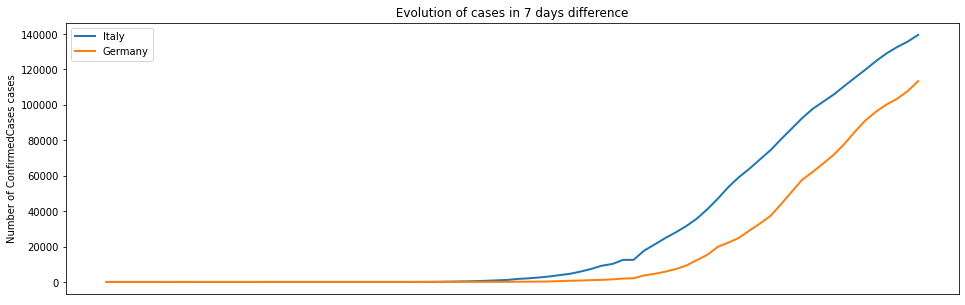

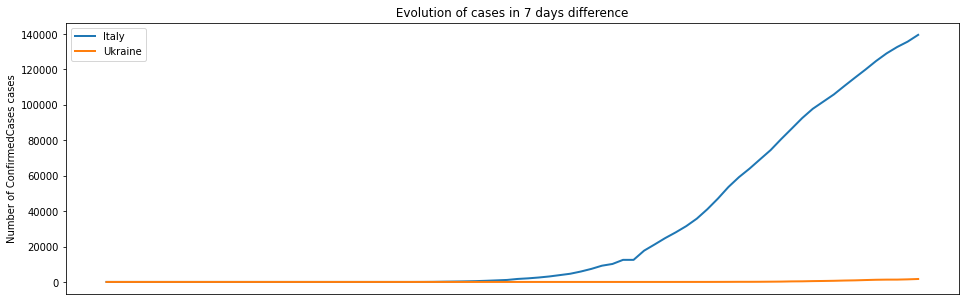

In [13]:
timeCompare(train_sum, 7,'Italy','Germany')
timeCompare(train_sum, 7,'Italy','Ukraine')

In [14]:
case='Fatalities'
def timeCompare_f(df, time,*argv):
    Coun1=argv[0]
    Coun2=argv[1]
    f,ax=plt.subplots(figsize=(16,5))
    labels=argv  
    country=df.loc[(df['Country_Region']==Coun1)]
    plt.plot(country['Date'],country[case],linewidth=2)
    plt.xticks([])
    plt.legend(labels)
    ax.set(title=' Evolution of actual cases',ylabel='Number of cases' )

    country2=df.loc[df['Country_Region']==Coun2]
    #country2['Date']=country2['Date']-datetime.timedelta(days=time)
    plt.plot(country2['Date'],country2[case],linewidth=2)
    #plt.xticks([])
    plt.legend(labels)
    ax.set(title=' Evolution of Fatalities in %d days difference '%time ,ylabel='Number of %s cases'%case )

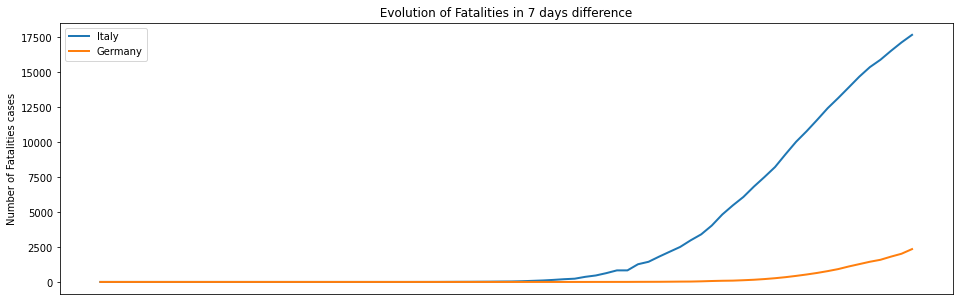

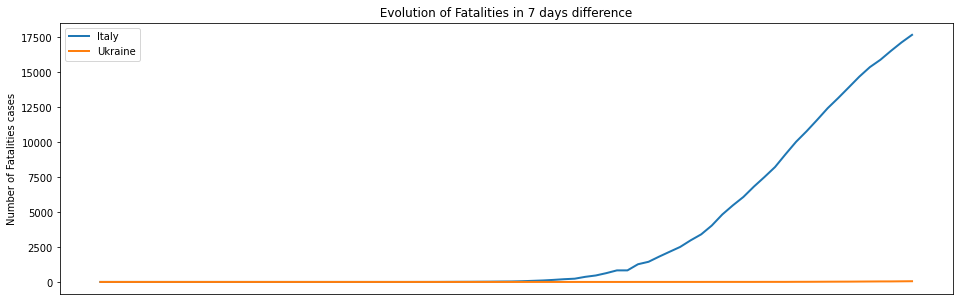

In [15]:
timeCompare_f(train_sum, 7,'Italy','Germany')
timeCompare_f(train_sum, 7,'Italy','Ukraine')

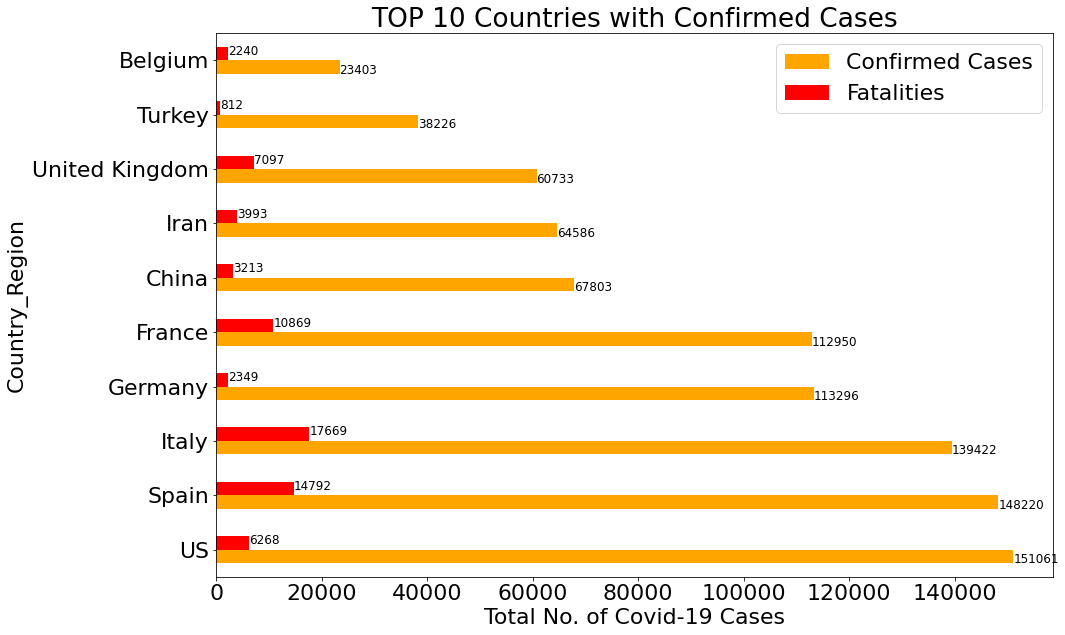

In [16]:
train_data_by_country = train.groupby(['Country_Region'],as_index=True).agg({'ConfirmedCases': 'max', 'Fatalities': 'max'})
train_data_by_country_confirm = train_data_by_country.sort_values(by=["ConfirmedCases"], ascending=False)

from itertools import cycle, islice

discrete_col = list(islice(cycle(['orange', 'r', 'g', 'k', 'b', 'c', 'm']), None, len(train_data_by_country_confirm.head(10))))
plt.rcParams.update({'font.size': 22})
train_data_by_country_confirm.head(10).plot(figsize=(15,10), kind='barh', color=discrete_col)
plt.legend(["Confirmed Cases", "Fatalities"]);
plt.xlabel("Total No. of Covid-19 Cases")
plt.title("TOP 10 Countries with Confirmed Cases")
ylocs, ylabs = plt.yticks()
for i, v in enumerate(train_data_by_country_confirm.head(10)["ConfirmedCases"][:]):
    plt.text(v+0.01, ylocs[i]-0.25, str(int(v)), fontsize=12)
for i, v in enumerate(train_data_by_country_confirm.head(10)["Fatalities"][:]):
    if v > 200: #disply for only >200 fatalities
        plt.text(v+0.01,ylocs[i]+0.1,str(int(v)),fontsize=12) 

In [17]:
train['MortalityRate'] = train['Fatalities'] / train['ConfirmedCases']
train['MortalityRate'] = train['MortalityRate'].fillna(0.0)

In [18]:
'''Confirmed Cases and Fatalities are cummulative sums of all the previous days. In order to understand the daily trend, I'll create a column for daily cases and deaths that will be the difference between the current value and the previous day's value'''
def add_daily_measures(df):
    df.loc[0,'Daily Cases'] = df.loc[0,'ConfirmedCases']
    df.loc[0,'Daily Deaths'] = df.loc[0,'Fatalities']
    for i in range(1,len(df)):
        df.loc[i,'Daily Cases'] = df.loc[i,'ConfirmedCases'] - df.loc[i-1,'ConfirmedCases']
        df.loc[i,'Daily Deaths'] = df.loc[i,'Fatalities'] - df.loc[i-1,'Fatalities']
    #Make the first row as 0 because we don't know the previous value
    df.loc[0,'Daily Cases'] = 0
    df.loc[0,'Daily Deaths'] = 0
    return df

df_world = train.copy()
df_world = df_world.groupby('Date',as_index=False)['ConfirmedCases','Fatalities'].sum()
df_world = add_daily_measures(df_world)

In [19]:
fig = go.Figure(data=[
    go.Bar(name='Cases', x=df_world['Date'], y=df_world['Daily Cases']),
    go.Bar(name='Deaths', x=df_world['Date'], y=df_world['Daily Deaths'])
])
# Change the bar mode
fig.update_layout(barmode='overlay', title='Worldwide daily Case and Death count')
fig.show()

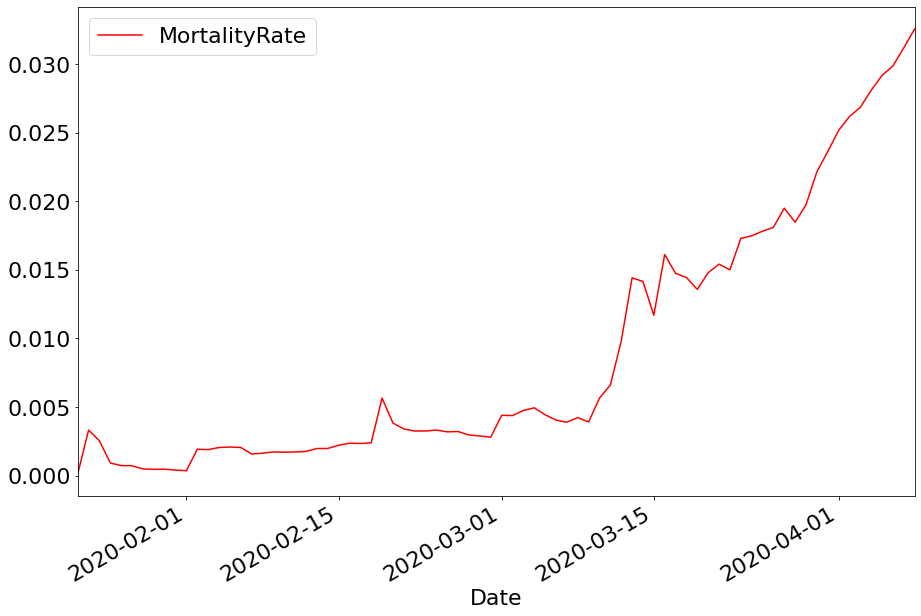

In [20]:
mort = train.copy()
mort['Date'] = pd.to_datetime(mort['Date'])
train_data_by_date = mort.groupby(['Date'],as_index=True).agg({'ConfirmedCases': 'sum','Fatalities': 'sum', 'MortalityRate':'mean'})

train_data_by_date.MortalityRate.plot(figsize=(15,10),x_compat=True, legend='Mortality Rate',color='r')

In [21]:
top_country_m = train[train['Date'] == curr_date].groupby(['Country_Region']).sum().sort_values(['MortalityRate'], ascending=False)
top_country_m.head(10)

,Id,ConfirmedCases,Fatalities,MortalityRate
Country_Region,,,,
US,1626318,428889.0,14690.0,1.449626
United Kingdom,375804,61474.0,7111.0,0.370122
China,265914,82809.0,3337.0,0.363610
Netherlands,105270,20682.0,2255.0,0.330826
Zimbabwe,35646,11.0,3.0,0.272727
France,148830,113959.0,10887.0,0.266123
Gambia,14328,4.0,1.0,0.250000
MS Zaandam,18774,9.0,2.0,0.222222
Bahamas,2130,40.0,7.0,0.175000


Text(0.5, 1.0, 'First 10 Countries with Highest Mortality Rate')

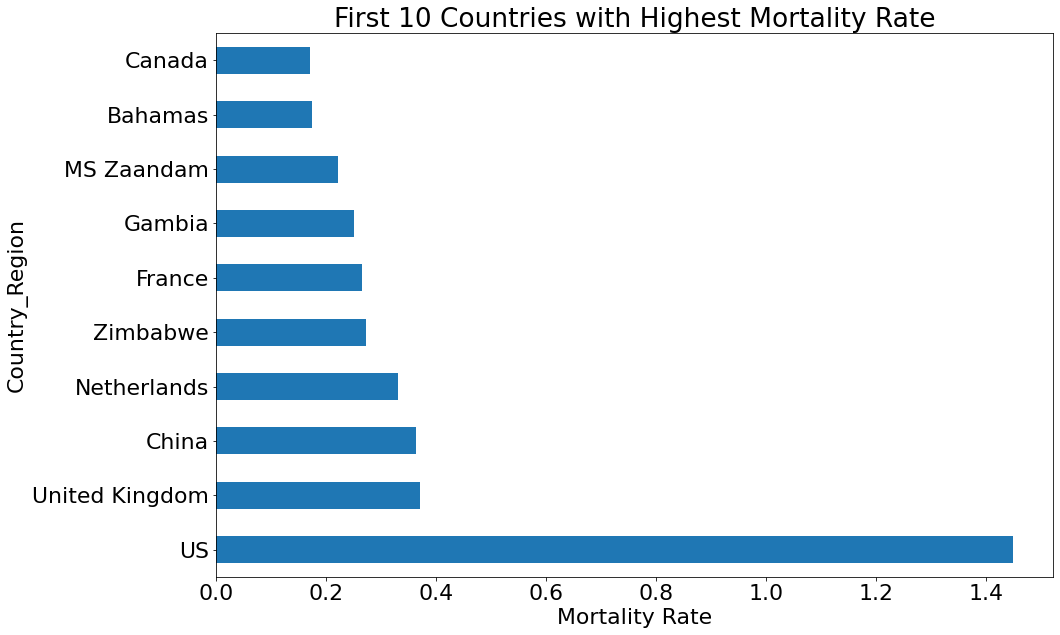

In [22]:
top_country_m.MortalityRate.head(10).plot(figsize=(15,10),kind='barh')
plt.xlabel("Mortality Rate")
plt.title("First 10 Countries with Highest Mortality Rate")


In [23]:
#now parts of processing
def create_features(df):
    df['day'] = df['Date'].dt.day
    df['month'] = df['Date'].dt.month
    df['dayofweek'] = df['Date'].dt.dayofweek
    df['dayofyear'] = df['Date'].dt.dayofyear
    df['quarter'] = df['Date'].dt.quarter
    df['weekofyear'] = df['Date'].dt.weekofyear
    return df
def train_dev_split(df, days):
    #Last days data as dev set
    date = df['Date'].max() - dt.timedelta(days=days)
    return df[df['Date'] <= date], df[df['Date'] > date]
def categoricalToInteger(df):
    #convert NaN Province State values to a string
    df.Province_State.fillna('NaN', inplace=True)
    #Define Ordinal Encoder Model
    oe = OrdinalEncoder()
    df[['Province_State','Country_Region']] = oe.fit_transform(df.loc[:,['Province_State','Country_Region']])
    return df

In [24]:
df_train = categoricalToInteger(train)
df_train.info()
df_train = create_features(df_train)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24414 entries, 0 to 24413
Data columns (total 7 columns):
Id                24414 non-null int64
Country_Region    24414 non-null float64
Province_State    24414 non-null float64
Date              24414 non-null datetime64[ns]
ConfirmedCases    24414 non-null float64
Fatalities        24414 non-null float64
MortalityRate     24414 non-null float64
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 1.3 MB


In [25]:
df_train, df_dev = train_dev_split(df_train,0)

columns = ['day','month','dayofweek','dayofyear','quarter','weekofyear','Province_State', 'Country_Region','ConfirmedCases','Fatalities']
df_train = df_train[columns]
df_dev = df_dev[columns]

In [26]:
df_test = categoricalToInteger(test)
df_test = create_features(test)
#Columns to select
columns = ['day','month','dayofweek','dayofyear','quarter','weekofyear','Province_State', 'Country_Region']

In [27]:
def RF():
    model = RandomForestRegressor(n_estimators = 100) 
    return model

def XGB():
    model = XGBRegressor(n_estimators=1300)
    return model

def LGBM():
    model = LGBMRegressor(iterations=2)
    return model

In [28]:
submission = []
for country in df_train.Country_Region.unique():
    df_train1 = df_train[df_train["Country_Region"]==country]
    for state in df_train1.Province_State.unique():
        df_train2 = df_train1[df_train1["Province_State"]==state]
        train = df_train2.values
        X_train, y_train = train[:,:-2], train[:,-2:]
        model1 = XGBRegressor(n_estimators=1100)
        model1.fit(X_train, y_train[:,0])
        model2 = XGBRegressor(n_estimators=1100)
        model2.fit(X_train, y_train[:,1])
        df_test1 = df_test[(df_test["Country_Region"]==country) & (df_test["Province_State"] == state)]
        ForecastId = df_test1.ForecastId.values
        df_test2 = df_test1[columns]
        y_pred1 = np.round(model1.predict(df_test2.values),5)
        y_pred2 = np.round(model2.predict(df_test2.values),5)
        for i in range(len(y_pred1)):
            d = {'ForecastId':ForecastId[i], 'ConfirmedCases':y_pred1[i], 'Fatalities':y_pred2[i]}
            submission.append(d)

In [29]:
df_submit = pd.DataFrame(submission)

df_submit.to_csv(r'submission.csv', index=False)